In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import numpy as np
import pandas as pd
import gc

In [3]:
store = pd.HDFStore('../Data/store1.h5')

In [4]:
print store

<class 'pandas.io.pytables.HDFStore'>
File path: ../Data/store1.h5
/miss             frame        (shape->[11437,3])    
/prop             frame        (shape->[2883630,254])
/train            frame        (shape->[90275,256])  


In [5]:
prop = store["prop"]
train = store["train"]

In [6]:
prop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2883630 entries, 0 to 2883629
Columns: 254 entries, id_parcel to cl3_num_bathroom_diff
dtypes: float32(205), int16(9), int64(18), int8(22)
memory usage: 2.7 GB


# 3Month

In [7]:
y = train.logerror
mid = np.percentile(y, 50)
y = y - mid
q1 = np.percentile(y, 25)
q3 = np.percentile(y, 75)
print q1, q3
interval = q3 - q1
fac = 8.0
interval = interval * fac / 2.
hi = interval + mid
lo = -interval + mid
print hi, lo

-0.0313 0.0332
0.264 -0.252


In [8]:
# split the data to 9 months for train and 3 months for test
x1 = train[train.month < 10]    # use for train
x0 = train[train.month > 9]     # use for test
print "Size of the x1 data frame: ", x1.shape
print "Size of the x0 data frame: ", x0.shape

y1 = x1['logerror'].values
y0 = x0['logerror'].values

index_hi = y1 > hi   # drop 1480 points 
index_lo = y1 < lo    # drop 947 points
print sum(index_hi), sum(index_lo)

y1 = y1[(~index_lo) & (~index_hi)]
x1 = x1[(~index_lo) & (~index_hi)]

print "Size of the x1 data frame: ", x1.shape
print "Size of the x0 data frame: ", x0.shape

Size of the x1 data frame:  (81733, 256)
Size of the x0 data frame:  (8542, 256)
2088 1432
Size of the x1 data frame:  (78213, 256)
Size of the x0 data frame:  (8542, 256)


In [10]:
import xgb
ncpu = 8
model = xgb.XGBoostReg(
        eval_metric = 'mae',
        nthread = ncpu,
        eta = 0.01,
        max_depth = 9,
        subsample = 1.,
        colsample_bytree = 1.0,
        min_child_weight = 70,
        silent = 1
        )
nround = 465
from sklearn.metrics import mean_absolute_error

/home/amin/Software/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
model.fit(x1.drop(["id_parcel", "month", "logerror"], axis=1), y1, num_boost_round= nround) # Train the model without outliers

In [12]:
from sklearn.metrics import mean_absolute_error

print "Error on training data ", mean_absolute_error(y1, model.predict(x1.drop(["id_parcel", "month", "logerror"], axis=1)))
print "Error on 3 months test ", mean_absolute_error(y0, model.predict(x0.drop(["id_parcel", "month", "logerror"], axis=1)))

Error on training data  0.0439984531379
Error on 3 months test  0.0646193197255


In [16]:
del train, prop
gc.collect()

8146

# get importance features

In [13]:
import operator
importance = model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

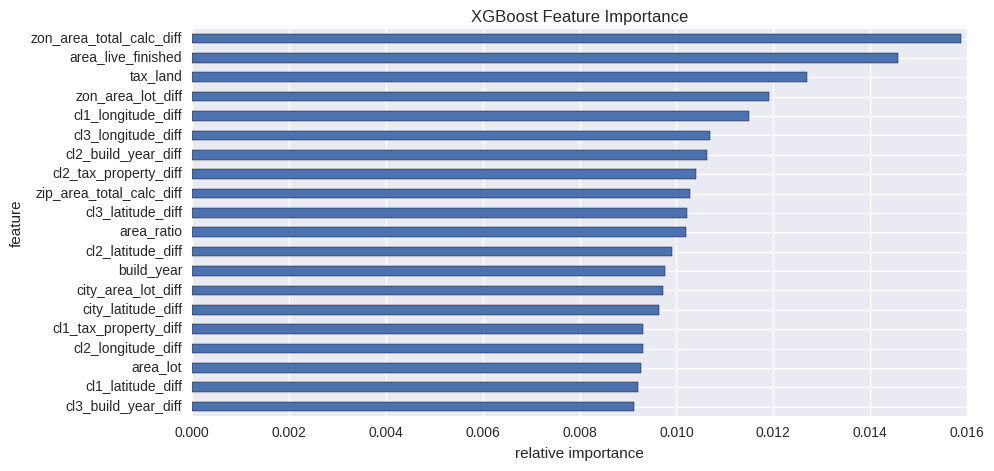

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

plt.figure()
df[-20:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [18]:
df[-100:].feature.values

array(['cl3_num_bedroom', 'area_total_calc', 'cl1_num_bedroom_diff',
       'zip_tax_property_diff', 'num_rot30_X', 'city_num_bedroom_diff',
       'zon_build_year', 'cl3_tax_building_area_diff', 'tax_property_area',
       'neighbor_latitude_diff', 'neighbor_tax_property_area_diff',
       'cl3_num_bedroom_diff', 'num_pool', 'cluster3',
       'cl3_num_bathroom_diff', 'cl2_num_bedroom_diff',
       'region_city_count', 'neighbor_tax_building_diff',
       'cl2_tax_total_diff', 'cl1_tax_total_diff',
       'cl3_tax_property_area_diff', 'cl3_tax_total_diff',
       'zip_build_year', 'area_total_finished', 'cl2_area_lot_diff',
       'city_build_year_diff', 'zon_num_bedroom_diff',
       'cl2_area_total_calc_diff', 'city_tax_property_diff',
       'neighbor_tax_property_diff', 'city_tax_property_area_diff',
       'cl1_tax_property_area_diff', 'region_zip', 'cl1_area_lot_diff',
       'zon_longitude_diff', 'region_zip_count',
       'cl3_area_total_calc_diff', 'zip_area_lot_diff', 'zonin

In [20]:
df[:50].feature.values

array(['pooltypeid7', 'num_rho', 'area_pool', 'cl1_longitude',
       'num_fireplace', 'cl3_longitude', 'zon_tax_total', 'num_75_bath',
       'num_garage', 'zon_tax_property_area', 'num_room', 'area_unknown',
       'zon_latitude', 'zip_longitude', 'num_phi', 'zon_tax_building',
       'type_aircon', 'zoning_landuse_county', 'type_zoning_landuse',
       'cl1_latitude', 'neighbor_longitude', 'neighbor_latitude',
       'cl2_longitude', 'zip_latitude', 'city_latitude', 'num_unit',
       'cl2_latitude', 'zon_longitude', 'cl3_latitude', 'type_heating',
       'zon_area_lot', 'city_tax_total', 'zon_num_bathroom',
       'cl1_tax_building', 'zon_tax_building_area', 'type_quality',
       'cl1_tax_property_area', 'neighbor_area_lot', 'city_longitude',
       'num_story', 'neighbor_num_bathroom', 'city_tax_property',
       'zon_tax_property', 'region_neighbor', 'city_area_total_calc',
       'cl1_tax_building_area', 'neighbor_tax_property',
       'zon_area_total_calc', 'city_num_bedroom',

In [21]:
len(importance)

236

In [22]:
features = list(df.feature.values)

In [23]:
ff = x1.drop(["id_parcel", "month", "logerror"], axis=1).columns

In [24]:
dd = []
for cc in ff:
    if cc not in features:
        print cc
        dd.append(cc)

type_architectural
area_basement
num_bathroom
num_bedroom
type_framing
num_bathroom_calc
type_deck
area_liveperi_finished
num_bath
pooltypeid10
region_county
type_story
type_material
area_shed
tax_year
num_rot75_X
num_rot75_Y


In [25]:
dd

['type_architectural',
 'area_basement',
 'num_bathroom',
 'num_bedroom',
 'type_framing',
 'num_bathroom_calc',
 'type_deck',
 'area_liveperi_finished',
 'num_bath',
 'pooltypeid10',
 'region_county',
 'type_story',
 'type_material',
 'area_shed',
 'tax_year',
 'num_rot75_X',
 'num_rot75_Y']

In [ ]:
## drop unimportant feeatures

In [60]:
model.fit(x1.drop(["id_parcel", "month", "logerror"] + dd, axis=1), y1, num_boost_round= nround) # Train the model without outliers

In [61]:
print "Error on training data ", mean_absolute_error(y1, model.predict(x1.drop(["id_parcel", "month", "logerror"] + dd, axis=1)))
print "Error on 3 months test ", mean_absolute_error(y0, model.predict(x0.drop(["id_parcel", "month", "logerror"] + dd, axis=1)))

Error on training data  0.0439984531379
Error on 3 months test  0.0646193197255


In [62]:
import operator
importance = model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
df.tail()

,feature,fscore
231,cl1_longitude_diff,0.011497
232,zon_area_lot_diff,0.011904
233,tax_land,0.012688
234,area_live_finished,0.014575
235,zon_area_total_calc_diff,0.015881


In [63]:
model.fit(x1.drop(["id_parcel", "month", "logerror", "area_live_finished"] + dd, axis=1), y1, num_boost_round= nround) # Train the model without outliers

In [64]:
print "Error on training data ", mean_absolute_error(y1, model.predict(x1.drop(["id_parcel", "month", "logerror", "area_live_finished"] + dd, axis=1)))
print "Error on 3 months test ", mean_absolute_error(y0, model.predict(x0.drop(["id_parcel", "month", "logerror", "area_live_finished"] + dd, axis=1)))

Error on training data  0.0440672693457
Error on 3 months test  0.0646406205857


In [65]:
import operator
importance = model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
df.tail()

,feature,fscore
229,cl2_build_year_diff,0.011288
230,cl1_longitude_diff,0.011768
231,tax_land,0.012247
232,zon_area_lot_diff,0.012816
233,zon_area_total_calc_diff,0.018774


In [18]:
model.fit(x1.drop(["id_parcel", "month", "logerror", "area_total_calc"] + dd, axis=1), y1, num_boost_round= nround) # Train the model without outliers

In [19]:
print "Error on training data ", mean_absolute_error(y1, model.predict(x1.drop(["id_parcel", "month", "logerror", "area_total_calc"] + dd, axis=1)))
print "Error on 3 months test ", mean_absolute_error(y0, model.predict(x0.drop(["id_parcel", "month", "logerror", "area_total_calc"] + dd, axis=1)))

Error on training data  0.0439990368085
Error on 3 months test  0.064597788293


In [ ]:
# area_total_calc can be drop